# MeerKAT-16 plots

By Nadia Steyn (and lots of programming help from Trystan)

In [8]:
import numpy as np 
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS #for FITS files
from astropy.coordinates import SkyCoord
import tqdm
import astropy.units as u 
from reproject.mosaicking import find_optimal_celestial_wcs, reproject_and_coadd #https://reproject.readthedocs.io/en/stable/mosaicking.html
from reproject import reproject_interp # function for constructing mosaics from multiple images
import warnings
from astropy.wcs import FITSFixedWarning # to kill the annoying warnings
warnings.simplefilter('ignore', FITSFixedWarning)

The 6 pointings:

In [3]:
gal_long_centre = [272.25,271.45,272.10,271.30,272.05,271.30]
gal_lat_centre = [-9.10,-9.20,-8.30,-8.50,-7.45,-7.70]

Mosaic1:

In [4]:
infile = "/Users/nadia/data/mosaic1.fits"
hdu1 = fits.open(infile)
reduced1 = hdu1[0].data[0] #reads the data from the fits file into an array, taking only one velocity slice
x_out = [] 
y_out = []

#Identifying the outer pixels of mosaic1:
for i in tqdm.tqdm(range(1,len(reduced1)-1)):
    for j in range(1,len(reduced1[0])-1):
        if reduced1[i][j] > -1000: #if i or j is not a nan
            if (reduced1[i-1][j] > -1000) and (reduced1[i+1][j] > -1000) and (reduced1[i][j-1]>-1000) and (reduced1[i][j+1]>-1000):
                val=True
            else:
                y_out.append(i)
                x_out.append(j)

100%|██████████| 390/390 [00:01<00:00, 276.47it/s]


Mosaic2:

In [5]:
infile = "/Users/nadia/data/mosaic2_vin.fits"
hdu2 = fits.open(infile)
reduced2 = hdu2[0].data[0] #reads the data from the fits file into an array, taking only one velocity slice
x_out2 = []
y_out2 = []

#Identifying the outer pixels of mosaic2:
for i in tqdm.tqdm(range(1,len(reduced2)-1)):
    for j in range(1,len(reduced2[0])-1):
        if reduced2[i][j] > -1000: #if i or j is not a nan
            if (reduced2[i-1][j] > -1000) and (reduced2[i+1][j] > -1000) and (reduced2[i][j-1]>-1000) and (reduced2[i][j+1]>-1000):
                val=True
            else:
                y_out2.append(i)
                x_out2.append(j)

100%|██████████| 561/561 [00:03<00:00, 141.62it/s]


Combine the two WCS's into one optimal WCS:

documentation: https://reproject.readthedocs.io/en/stable/mosaicking.html

In [44]:
wcs1 = WCS(hdu1[0].header,naxis=2) 
ra_out,dec_out = wcs1.pixel_to_world_values(x_out,y_out)

wcs2 = WCS(hdu2[0].header,naxis=2) 
ra_out2,dec_out2 = wcs2.pixel_to_world_values(x_out2,y_out2)

# The next function can be used to find an output WCS and shape (i.e. an output header) 
wcs_out, shape_out = find_optimal_celestial_wcs([(reduced1,wcs1),(reduced2,wcs2)])

Image reprojection:

documentation: https://reproject.readthedocs.io/en/stable/api/reproject.mosaicking.reproject_and_coadd.html

In [25]:
# I am choosing the reprojection algorithm 'reproject_exact' (fyi, I can't see the difference between functions)
# The following function returns the reprojected array:
array, _ = reproject_and_coadd([(reduced1,wcs1),(reduced2,wcs2)], wcs_out, \
                               shape_out=shape_out, reproject_function=reproject_interp, combine_function='mean')

x_out_new,y_out_new = wcs_out.world_to_pixel_values(ra_out ,dec_out)
x_out2_new,y_out2_new = wcs_out.world_to_pixel_values(ra_out2,dec_out2)
x_centre, y_centre = wcs_out.world_to_pixel_values(ra_c,dec_c)

Now that the images are mosaicked together, we can plot them together:

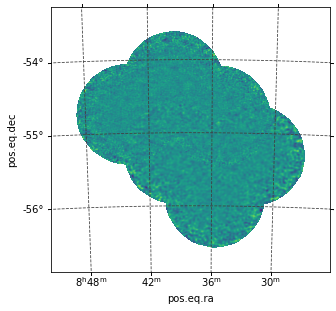

In [34]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection=wcs_out)
ax.imshow(array)
plt.grid(color='0.25', ls='--')

# Plots! :)

Individual pointings:

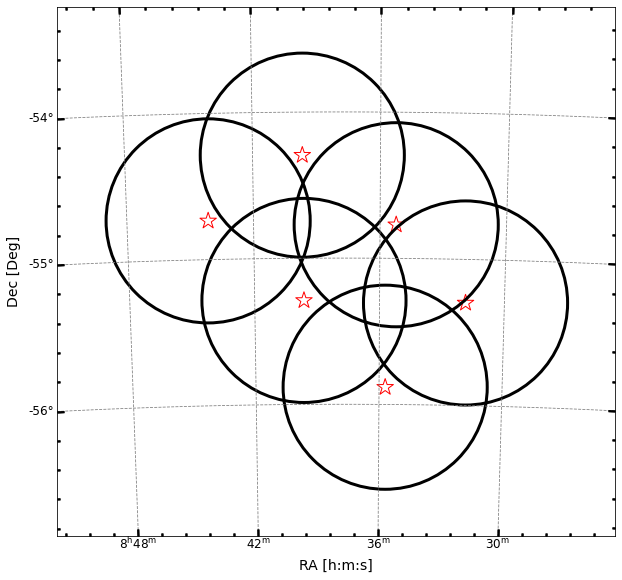

In [30]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=wcs_out)
ax.imshow(array,alpha=0) #slices will be invisible but the mosaics won't be stretched
#ax.scatter(x_centre,y_centre, marker='*', edgecolor='r', facecolor='None', s=300) #centre-points
plt.grid(color='grey', ls='--')
ax.set_xlabel("RA [h:m:s]",size=14)
ax.set_ylabel("Dec [Deg]",size=14)
#Tick labels:
plt.tick_params(axis='both',labelsize=12)
#Tick marks:
ax.axes.tick_params(which='major', length=7, direction='in')
ax.axes.tick_params(which='minor', length=3)
ax.axes.tick_params(which='both', width=2)
#Show minor tick marks:
ax.coords[0].display_minor_ticks(True)
ax.coords[1].display_minor_ticks(True)

for i in range(len(x_centre)):
    i = plt.Circle((x_centre[i], y_centre[i]), 2513.808/16, edgecolor='k',facecolor='None',lw=3) 
    ax.add_patch(i)
# radius (in pixels) = radius in arcsecs/arcsecs per pixel

Outlines only:

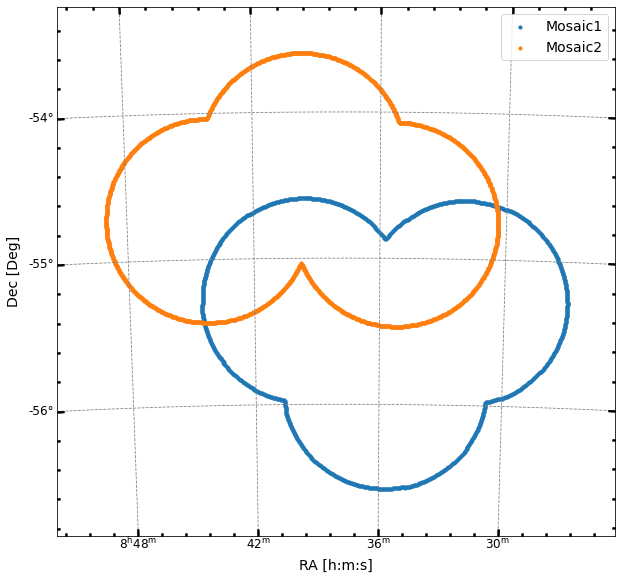

In [37]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=wcs_out) 
ax.imshow(array,alpha=0) #slices will be invisible but the mosaics won't be stretched
ax.scatter(x_out_new,y_out_new,s=10,label='Mosaic1')
ax.scatter(x_out2_new,y_out2_new,s=10,label='Mosaic2')
ax.legend(fontsize=14,loc=1)
plt.grid(color='grey', ls='--')
ax.set_xlabel("RA [h:m:s]",size=14)
ax.set_ylabel("Dec [Deg]",size=14)
#Tick labels:
plt.tick_params(axis='both',labelsize=12)
#Tick marks:
ax.axes.tick_params(which='major', length=7, direction='in')
ax.axes.tick_params(which='minor', length=3)
ax.axes.tick_params(which='both', width=2)
#Show minor tick marks:
ax.coords[0].display_minor_ticks(True)
ax.coords[1].display_minor_ticks(True)

With visual and Sofia detections:

no of vis sources: 198
no of sofia sources: 66
no of visual and sofia matches: 47 (I think! I have to double check!)


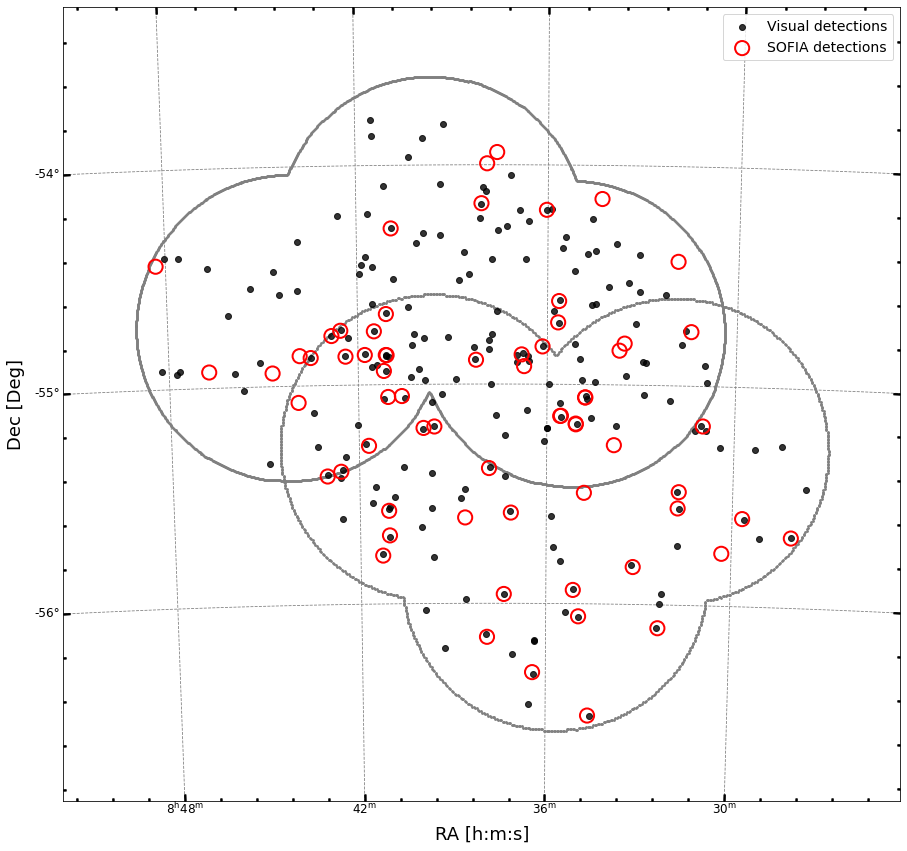

In [43]:
infile1 = '/Users/nadia/Desktop/MK16/SARAO conference/visual_no_rejects.txt' #in_vis = Y, reject_list = N. 198 sources.
mosaic, x_vis, y_vis, z_vis, ra_h, ra_m, ra_s, dec_d, dec_m, dec_s, vel_vis = np.loadtxt(infile1, usecols=(0,7,8,9,10,11,12,13,14,15,16), unpack=True)
classification, in_sofia = np.loadtxt(infile1, usecols=(19,17), dtype=str, unpack=True)
print(f"no of vis sources: {len(x_vis)}")

ra_vis = (ra_h + ra_m/60 + ra_s/(60*60)) * (360/24)
dec_vis = (dec_d - dec_m/60 - dec_s/(60*60))
x_vis_new, y_vis_new = wcs_out.world_to_pixel_values(ra_vis ,dec_vis)

infile2 = '/Users/nadia/Desktop/MK16/SARAO conference/sofia_no_dups.txt' #in_sofia = Y, no dup IDs.
Rel, x_sof, y_sof, z_sof, vopt, ra_sof, dec_sof = np.loadtxt(infile2, usecols=(3,4,5,6,7,11,12), unpack=True)
In_vis, Reject_list, Classification = np.loadtxt(infile2, usecols=(8,9,10), dtype=str, unpack=True)
print(f"no of sofia sources: {len(x_sof)}")
print("no of visual and sofia matches: 47 (I think! I have to double check!)")

x_sof_new, y_sof_new = wcs_out.world_to_pixel_values(ra_sof, dec_sof)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection=wcs_out) 
ax.imshow(array,alpha=0) #slices will be invisible but the mosaics won't be stretched
ax.scatter(x_out_new,y_out_new, s=3, color='0.5')
ax.scatter(x_out2_new,y_out2_new, s=3, color='0.5')
ax.scatter(x_vis_new, y_vis_new, color='k', alpha=0.8, label='Visual detections')
ax.scatter(x_sof_new, y_sof_new, edgecolor='r',facecolor='None',s=200, lw=2,label='SOFIA detections')

ax.legend(fontsize=14,loc=1)
plt.grid(color='grey', ls='--')
ax.set_axisbelow(True)
ax.set_xlabel("RA [h:m:s]",size=18)
ax.set_ylabel("Dec [Deg]",size=18)

#Tick labels:
plt.tick_params(axis='both',labelsize=12)
#Tick marks:
ax.axes.tick_params(which='major', length=7, direction='in')
ax.axes.tick_params(which='minor', length=3)
ax.axes.tick_params(which='both', width=2)
#Show minor tick marks:
ax.coords[0].display_minor_ticks(True)
ax.coords[1].display_minor_ticks(True)